***

# __Utilizing Machine Learning for High Frequency Algorithmic Trading__


##### __Name:__ Masixole Boya<br>__Student number:__ 1869204

***

# __Imports__

In [23]:
from datetime import datetime
import pandas as pd
import pandas_ta as ta
from scipy.stats import linregress
import MetaTrader5 as mt5
import requests
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import pytz
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
# from secret_login import Secret_Login, IC_Markets_Login, Wandb_Login
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.models import load_model
import sys

sys.path.append('../../login_info')
import MT5_IC_secret_login
from MT5_IC_secret_login import Secret_Login, IC_Markets_Login, Wandb_Login, OctaFx_Login
from MT5_IC_login_function import login_to_mt5



# __1. MetaTrader 5 API__ : Setup

### __1.1 Initialize Application__

In [2]:
mt5.initialize()

True

### __1.2 Login__


In [3]:
login_success = login_to_mt5()

51944578
ICMarketsSC-Demo
Account : 51944578
Password : @0p63lC@FWABrr
Server : ICMarketsSC-Demo
Connected to account #51944578


In [3]:
# temp = IC_Markets_Login()

# account = mt5.account_info().login

# password = temp.password

# server = mt5.account_info().server

# print(f"Account : {account}")
# print(f"password : {password}")
# print(f"Server : {server}")


Account : 51944578
password : @0p63lC@FWABrr
Server : ICMarketsSC-Demo


In [4]:
# authorized = mt5.login(account,password,server)

# if authorized:
#     print("connected to account #{}".format(account))
# else:
#     print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))

connected to account #51944578


# __2. MetaTrader 5 API__ : Retrieving Data

In [4]:
ticker = 'EURUSD'
frequency = mt5.TIMEFRAME_M1

# Define the date range correctly
to_date = datetime.now()
from_date = datetime(2014, 1, 1)

In [5]:
# range_rates = mt5.copy_rates_range(ticker,frequency,to_date, from_date)

range_rates = mt5.copy_rates_range(ticker, frequency, from_date, to_date)

range_rates

array([(1388617200, 1.3755 , 1.3755 , 1.37547, 1.37547,  5, 101, 0),
       (1388617260, 1.37547, 1.37549, 1.3754 , 1.37541, 50,  62, 0),
       (1388617320, 1.37541, 1.37552, 1.37525, 1.37526, 49,  32, 0), ...,
       (1725395280, 1.10357, 1.10361, 1.10356, 1.10357, 16,   0, 0),
       (1725395340, 1.10357, 1.10364, 1.10356, 1.10362, 41,   0, 0),
       (1725395400, 1.10361, 1.10361, 1.10346, 1.10351, 49,   0, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [6]:
data = pd.DataFrame(range_rates)
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,1388617200,1.37550,1.37550,1.37547,1.37547,5,101,0
1,1388617260,1.37547,1.37549,1.37540,1.37541,50,62,0
2,1388617320,1.37541,1.37552,1.37525,1.37526,49,32,0
3,1388617380,1.37534,1.37546,1.37520,1.37530,16,20,0
4,1388617440,1.37531,1.37534,1.37530,1.37533,14,38,0
...,...,...,...,...,...,...,...,...
3952143,1725395160,1.10360,1.10362,1.10347,1.10347,30,0,0
3952144,1725395220,1.10347,1.10357,1.10346,1.10355,32,0,0
3952145,1725395280,1.10357,1.10361,1.10356,1.10357,16,0,0
3952146,1725395340,1.10357,1.10364,1.10356,1.10362,41,0,0


In [7]:
data['time'] = pd.to_datetime(data['time'],unit = 's')
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,2014-01-01 23:00:00,1.37550,1.37550,1.37547,1.37547,5,101,0
1,2014-01-01 23:01:00,1.37547,1.37549,1.37540,1.37541,50,62,0
2,2014-01-01 23:02:00,1.37541,1.37552,1.37525,1.37526,49,32,0
3,2014-01-01 23:03:00,1.37534,1.37546,1.37520,1.37530,16,20,0
4,2014-01-01 23:04:00,1.37531,1.37534,1.37530,1.37533,14,38,0
...,...,...,...,...,...,...,...,...
3952143,2024-09-03 20:26:00,1.10360,1.10362,1.10347,1.10347,30,0,0
3952144,2024-09-03 20:27:00,1.10347,1.10357,1.10346,1.10355,32,0,0
3952145,2024-09-03 20:28:00,1.10357,1.10361,1.10356,1.10357,16,0,0
3952146,2024-09-03 20:29:00,1.10357,1.10364,1.10356,1.10362,41,0,0


In [18]:
print(f'first time : \n{data.head(1)['time']}')
print(f"\nLast time : \n{data.tail(1)['time'] }")

first time : 
0   2014-01-01 23:00:00
Name: time, dtype: datetime64[ns]

Last time : 
3952143   2024-09-03 20:26:00
Name: time, dtype: datetime64[ns]


# __3. Preprocessing Data__

### __3.1 Data Visualization__

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3952148 entries, 0 to 3952147
Data columns (total 22 columns):
 #   Column                Dtype         
---  ------                -----         
 0   time                  datetime64[ns]
 1   open                  float64       
 2   high                  float64       
 3   low                   float64       
 4   close                 float64       
 5   tick_volume           uint64        
 6   spread                int32         
 7   real_volume           uint64        
 8   SMA_10                float64       
 9   SMA_20                float64       
 10  EMA_20                float64       
 11  MACD                  float64       
 12  MACD_Signal           float64       
 13  MACD_Histogram        float64       
 14  RSI_14                float64       
 15  slope_SMA_10          float64       
 16  slope_SMA_20          float64       
 17  slope_EMA_20          float64       
 18  slope_RSI_14          float64       
 19  

In [ ]:
data.set_index('time', inplace=True)

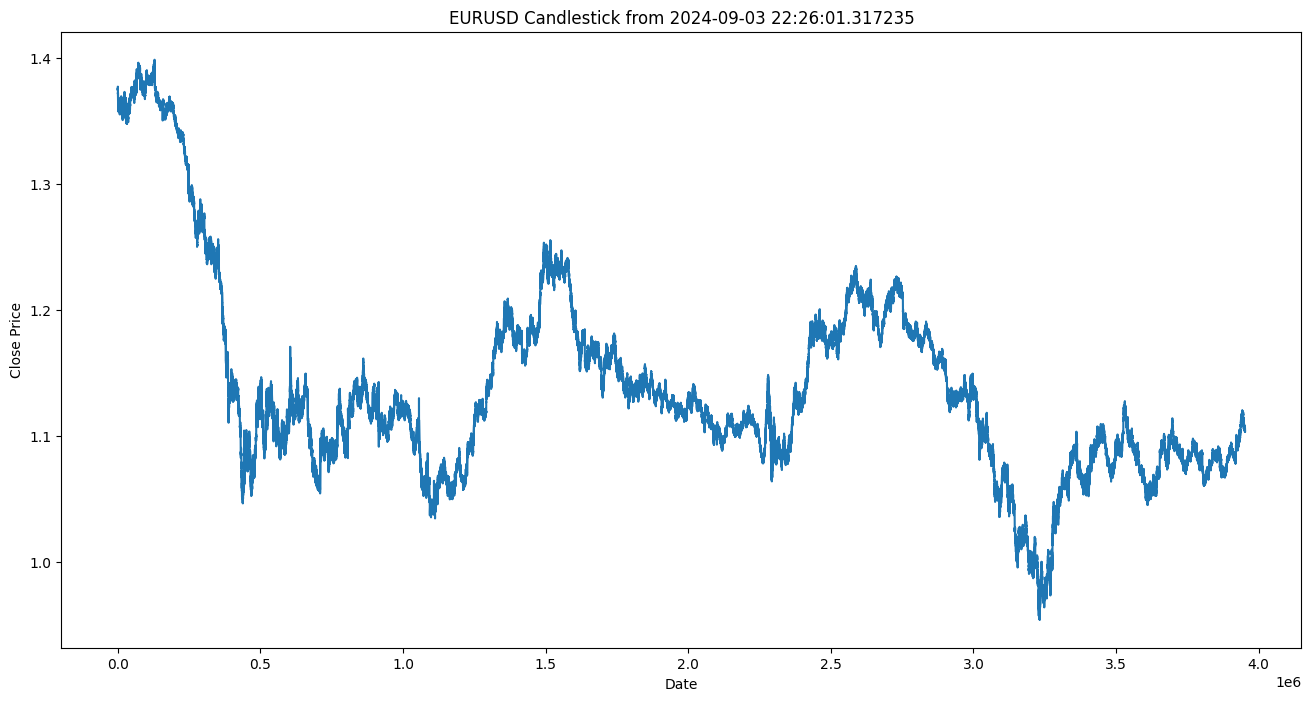

In [19]:
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Candlestick from {to_date}')
plt.plot(data['close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

### __3.2 Data Cleaning__ 

# __4. Technical Analysis__

## __4.1 Indicators__

In [11]:
data.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

#### __4.1.1 Simple Moving Average (SMA)__

In [15]:
data['SMA_10'] = ta.sma(data['close'], length=10)
data['SMA_20'] = ta.sma(data['close'], length=20)

#### __4.1.2 Exponential Moving Average (EMA)__

In [17]:
data['EMA_20'] = ta.ema(data['close'], length=20)

#### __4.1.3 Moving Average Convergence Divergence (MACD)__

In [18]:

macd = ta.macd(data['close'])

# Add the MACD, Signal, and Histogram to your DataFrame
data['MACD'] = macd['MACD_12_26_9']
data['MACD_Signal'] = macd['MACDs_12_26_9']
data['MACD_Histogram'] = macd['MACDh_12_26_9']

#### __4.1.4 Relative Strength Index (RSI)__

In [19]:
data['RSI_14'] = ta.rsi(data['close'], length=14)

In [ ]:
data.head()

### __4.2 Calculating Slope__

I calculate the slope of the indicators over a rolling window using linear regression. The slope tells us the direction ( or indicates the rate of change in the values over time) and strength of the trend over a specified number of periods.

The calculated slope reflects the trend's direction and magnitude:

- Positive Slope: Indicates an upward trend in the data.
- Negative Slope: Indicates a downward trend.
- Slope Magnitude: The greater the magnitude, the steeper the trend.

In [24]:
def get_slope(array):
    '''
    Parameters
    array: A sequence of numerical values (e.g., SMA values) over which the slope will be calculated. The function expects this to be a NumPy array.
    Returns
    slope: The slope of the linear regression line fitted to the input array.
    '''
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

In [25]:
back_roll_by = 4

indicator_columns = ['SMA_10','SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Histogram']  


for column in indicator_columns:
    slope_column_name = f'slope_{column}'
    data[slope_column_name] = data[column].rolling(window=back_roll_by).apply(get_slope, raw=True)


In [ ]:
# back_roll_by = 4

# data['slope_SMA_10'] = data['SMA_10'].rolling(window=back_roll_by).apply(get_slope, raw= True)

In [29]:
data.sample(10)

,time,open,high,low,close,tick_volume,spread,real_volume,SMA_10,SMA_20,...,MACD_Signal,MACD_Histogram,RSI_14,slope_SMA_10,slope_SMA_20,slope_EMA_20,slope_RSI_14,slope_MACD,slope_MACD_Signal,slope_MACD_Histogram
2272920,2020-03-02 19:17:00,1.11766,1.11788,1.11748,1.11780,116,0,0,1.117601,1.117105,...,0.000563,2.096796e-05,65.457431,7.370000e-05,0.000083,0.000076,-5.710757,-1.172157e-05,1.132312e-05,-2.304469e-05
1276802,2017-06-13 02:23:00,1.12009,1.12009,1.12001,1.12002,55,0,55,1.120110,1.120094,...,-0.000032,4.080162e-06,41.583459,4.300000e-06,-0.000002,-0.000004,-3.681086,-5.713078e-07,2.382019e-06,-2.953327e-06
2712132,2021-05-07 05:00:00,1.20658,1.20670,1.20655,1.20666,30,0,0,1.206456,1.206464,...,0.000048,9.810403e-06,65.120349,1.000000e-06,0.000021,0.000014,5.258977,6.664336e-06,-3.107249e-07,6.975061e-06
3482896,2023-06-01 02:27:00,1.06956,1.06956,1.06950,1.06956,21,0,0,1.069554,1.069507,...,0.000058,-6.983589e-06,62.068977,8.900000e-06,0.000007,0.000005,2.189174,-1.755910e-06,-1.899224e-06,1.433139e-07
2046357,2019-07-22 23:38:00,1.12072,1.12077,1.12072,1.12076,13,0,0,1.120794,1.120835,...,-0.000012,-1.322980e-05,40.436273,-1.540000e-05,-0.000006,-0.000010,1.158137,-5.881520e-06,-3.444616e-06,-2.436904e-06
2416855,2020-07-20 22:48:00,1.14446,1.14446,1.14441,1.14443,19,0,0,1.144411,1.144369,...,0.000048,1.832715e-07,56.891268,1.170000e-05,0.000002,0.000008,0.620720,1.016572e-06,1.854254e-07,8.311469e-07
3378105,2023-02-20 00:49:00,1.06900,1.06904,1.06896,1.06899,81,38,0,1.069051,1.068931,...,0.000057,7.987883e-06,54.807532,3.100000e-06,0.000013,0.000005,-3.734009,-5.670930e-06,4.279157e-06,-9.950087e-06
192283,2014-07-11 02:59:00,1.35964,1.35966,1.35961,1.35961,7,4,0,1.359762,1.359778,...,-0.000019,-1.470147e-05,36.650004,-9.100000e-06,-0.000011,-0.000013,-4.693719,-9.147259e-06,-1.789706e-06,-7.357553e-06
819236,2016-03-23 09:38:00,1.11845,1.11891,1.11844,1.11881,111,7,91350000,1.118939,1.118746,...,-0.000067,8.711800e-06,47.991000,-3.840000e-05,0.000017,-0.000024,0.127852,-1.845276e-05,4.815975e-06,-2.326874e-05
1515857,2018-02-15 21:30:00,1.24986,1.24998,1.24985,1.24995,69,50,0,1.249852,1.249842,...,0.000098,-1.783574e-05,57.946590,3.600000e-06,0.000006,0.000008,2.210984,-2.405056e-06,-5.942538e-06,3.537482e-06


# __5. Preparing Data__

### __5.1 Scaling__

In [ ]:
# numerical_features = ['open', 'high', 'low', 'close'] 


# data[numerical_features] = data[numerical_features]

# scaler = MinMaxScaler()
# data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [31]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['close']])
data['close'] = scaled_data

In [32]:

data.sample(5)

,time,open,high,low,close,tick_volume,spread,real_volume,SMA_10,SMA_20,...,MACD_Histogram,RSI_14,slope_SMA_10,slope_SMA_20,slope_EMA_20,slope_RSI_14,slope_MACD,slope_MACD_Signal,slope_MACD_Histogram,scaled_close
2915762,2021-11-23 19:24:00,1.12654,1.12655,1.12629,-0.160214,44,0,0,1.126506,1.126445,...,1.205285e-05,48.239540,0.000016,0.000017,0.000004,-0.309587,-1.583720e-07,0.000005,-0.000005,-0.160214
2139063,2019-10-21 11:09:00,1.11660,1.11678,1.11656,-0.280793,45,0,0,1.116470,1.116475,...,8.763522e-07,68.566126,0.000007,0.000027,0.000023,4.225821,5.254869e-06,-0.000004,0.000009,-0.280793
1537104,2018-03-08 16:23:00,1.23937,1.23964,1.23930,1.254122,315,0,0,1.239513,1.239599,...,8.476683e-05,47.611195,0.000032,-0.000010,-0.000013,-0.816281,1.534609e-05,0.000023,-0.000008,1.254122
3601582,2023-09-25 19:44:00,1.05927,1.05928,1.05905,-1.002017,30,0,0,1.059185,1.059259,...,-1.318382e-05,41.379254,-0.000004,-0.000011,-0.000006,-1.013501,9.230002e-07,-0.000003,0.000004,-1.002017
1665665,2018-07-12 13:18:00,1.16762,1.16762,1.16752,0.353840,44,0,0,1.167527,1.167620,...,-1.606197e-05,48.183682,-0.000033,-0.000011,-0.000001,3.166137,8.301346e-06,-0.000007,0.000015,0.353840


### __5.2 Creating training data__

#### __5.2.1 Preparing Lagged Data__

- __`df`:__ This is a DataFrame containing the original data.
  
- __`lag_steps:`__ This is an integer representing the number of time steps to lag the time unit by. It determines how many previous values of the target variable ('close') to include in the lagged DataFrame.
  
- __`lagged_df:`__ This is a new DataFrame that will store the lagged data.
  
- __`pd.DataFrame(index=df.index)`:__ This creates a new DataFrame with the same index as the original DataFrame df. The index represents the date and time of each data point.
  
- __`lagged_df['DateTime'] = df.index:`__ This creates a new column in the lagged_df DataFrame called 'DateTime', and it copies the index of the original DataFrame df. This column will store the date and time information.
  
- __`lagged_df['ActualValue'] = df['close']:`__ This creates a new column in the lagged_df DataFrame called 'ActualValue', and it copies the values from the 'close' column of the original DataFrame df. This column will store the actual values of the target variable.
  
- __`Loop:`__ This loop iterates from 1 to lag_steps (inclusive). For each iteration:
    - __`lagged_df[f'PrevValue_{i}'] = df['close'].shift(i):`__ This creates a new column in the lagged_df DataFrame for each lagged value. The column name includes the prefix 'PrevValue_' followed by the lag index i. It shifts the values of the 'close' column of the original DataFrame df upwards by i time steps and stores them in the new column. This effectively creates lagged features for the target variable.
  
- __`return lagged_df.dropna():`__ This returns the lagged DataFrame after dropping any rows with missing values (NaN). Since creating lagged features involves shifting the data, the first few rows will contain NaN values where there is no data available for the lagged features.


In [ ]:
# go_back_by = 10

# def create_lagged_dataframe(df, lag_steps=go_back_by):
#     lagged_df = pd.DataFrame(index=df.index)
#     lagged_df['DateTime'] = df.index
#     lagged_df['ActualValue'] = df['close']

#     #Creating lagged columns for previous values
#     for i in range(1, lag_steps + 1):
#         lagged_df[f'PrevValue_{i}'] = df['close'].shift(i)

#     return lagged_df.dropna()

# lagged_df = create_lagged_dataframe(data)
# lagged_df.head()


,DateTime,ActualValue,PrevValue_1,PrevValue_2,PrevValue_3,PrevValue_4,PrevValue_5,PrevValue_6,PrevValue_7,PrevValue_8,PrevValue_9,PrevValue_10
time,,,,,,,,,,,,
1994-01-17,1994-01-17,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213,1.1233,1.1260,1.1216
1994-01-18,1994-01-18,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213,1.1233,1.1260
1994-01-19,1994-01-19,1.1193,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213,1.1233
1994-01-20,1994-01-20,1.1259,1.1193,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213
1994-01-21,1994-01-21,1.1144,1.1259,1.1193,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328


In [33]:
go_back_by = 3

def create_lagged_dataframe(df, lag_steps=go_back_by, columns_to_lag=None):
    if columns_to_lag is None:
        columns_to_lag = df.columns  # By default, lag all columns

    lagged_df = pd.DataFrame(index=df.index)
    lagged_df['DateTime'] = df.index
    lagged_df['ActualValue'] = df['close']  # Keep 'ActualValue' for the close price

    # Creating lagged columns for each selected column
    for column in columns_to_lag:
        for i in range(1, lag_steps + 1):
            lagged_df[f'{column}_lag_{i}'] = df[column].shift(i)

    return lagged_df.dropna()

# Specify the columns you want to lag
columns_to_lag = ['close', 'SMA_10', 'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Histogram']

lagged_df = create_lagged_dataframe(data, lag_steps=go_back_by, columns_to_lag=columns_to_lag)


,DateTime,ActualValue,close_lag_1,close_lag_2,close_lag_3,SMA_10_lag_1,SMA_10_lag_2,SMA_10_lag_3,SMA_20_lag_1,SMA_20_lag_2,...,RSI_14_lag_3,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_Signal_lag_1,MACD_Signal_lag_2,MACD_Signal_lag_3,MACD_Histogram_lag_1,MACD_Histogram_lag_2,MACD_Histogram_lag_3
36,36,2.951599,2.946850,2.947100,2.946975,1.375227,1.375212,1.375196,1.375158,1.375128,...,47.768647,-0.000011,-4.340305e-07,1.069187e-05,-0.000020,-0.000022,-0.000027,0.000009,0.000021,0.000038
37,37,2.947850,2.951599,2.946850,2.947100,1.375277,1.375227,1.375212,1.375196,1.375158,...,47.955041,0.000012,-1.074140e-05,-4.340305e-07,-0.000013,-0.000020,-0.000022,0.000025,0.000009,0.000021
38,38,2.946850,2.947850,2.951599,2.946850,1.375284,1.375277,1.375227,1.375206,1.375196,...,47.589257,0.000005,1.161882e-05,-1.074140e-05,-0.000010,-0.000013,-0.000020,0.000015,0.000025,0.000009
39,39,2.949724,2.946850,2.947850,2.951599,1.375253,1.375284,1.375277,1.375206,1.375206,...,54.664860,-0.000006,5.073483e-06,1.161882e-05,-0.000009,-0.000010,-0.000013,0.000003,0.000015,0.000025
40,40,2.950599,2.949724,2.946850,2.947850,1.375261,1.375253,1.375284,1.375229,1.375206,...,49.036464,0.000003,-6.494215e-06,5.073483e-06,-0.000007,-0.000009,-0.000010,0.000010,0.000003,0.000015


In [34]:
lagged_df.sample()


,DateTime,ActualValue,close_lag_1,close_lag_2,close_lag_3,SMA_10_lag_1,SMA_10_lag_2,SMA_10_lag_3,SMA_20_lag_1,SMA_20_lag_2,...,RSI_14_lag_3,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_Signal_lag_1,MACD_Signal_lag_2,MACD_Signal_lag_3,MACD_Histogram_lag_1,MACD_Histogram_lag_2,MACD_Histogram_lag_3
788191,788191,-0.475093,-0.474594,-0.475718,-0.478092,1.101414,1.10149,1.101554,1.101671,1.101676,...,39.725248,-0.000107,-0.000103,-0.000088,8.878714e-08,0.000027,0.000059,-0.000107,-0.00013,-0.000147


In [37]:
lagged_df.shape

(3952112, 26)

In [35]:
lagged_df.columns


Index(['DateTime', 'ActualValue', 'close_lag_1', 'close_lag_2', 'close_lag_3',
       'SMA_10_lag_1', 'SMA_10_lag_2', 'SMA_10_lag_3', 'SMA_20_lag_1',
       'SMA_20_lag_2', 'SMA_20_lag_3', 'EMA_20_lag_1', 'EMA_20_lag_2',
       'EMA_20_lag_3', 'RSI_14_lag_1', 'RSI_14_lag_2', 'RSI_14_lag_3',
       'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3', 'MACD_Signal_lag_1',
       'MACD_Signal_lag_2', 'MACD_Signal_lag_3', 'MACD_Histogram_lag_1',
       'MACD_Histogram_lag_2', 'MACD_Histogram_lag_3'],
      dtype='object')

#### __5.2.2 Prepare LSTM Data__

- __`lagged_df:`__ This is a DataFrame containing the lagged data.

- __`dates:`__ This variable stores the date and time information from the lagged DataFrame.

- __`X:`__ This variable stores the input features for the LSTM model. It consists of all columns from the lagged DataFrame except 'DateTime' and 'ActualValue', converted to float32 data type.

- __`y:`__ This variable stores the target variable for the LSTM model, which is the 'ActualValue' column from the lagged DataFrame, converted to float32 data type.

- __`return:`__ The function returns three variables: dates, X, and y, containing the respective data.



In [38]:
def prepare_lstm_data(lagged_df):
    dates = lagged_df['DateTime']
    X = lagged_df.drop(columns=['DateTime', 'ActualValue']).astype(np.float32)
    y = lagged_df['ActualValue'].astype(np.float32)

    return dates, X.values, y.values


dates, X, y = prepare_lstm_data(lagged_df)
print("Dates:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates: (3952112,)
X shape: (3952112, 24)
y shape: (3952112,)


### __5.3 Spliting: Training, Validation, Testing Data__

#### __Split Data__

- __`dates:`__ This variable contains the date and time information.

- __`X:`__ This variable contains the input features for the model.

- __`y:`__ This variable contains the target variable for the model.

- __`x_train:`__ This variable contains the input features for the training set.

- __`y_train:`__ This variable contains the target variable for the training set.

- __`x_val:`__ This variable contains the input features for the validation set.

- __`y_val:`__ This variable contains the target variable for the validation set.

- __`x_test:`__ This variable contains the input features for the test set.

- __`y_test:`__ This variable contains the target variable for the test set.

- __`train_data:`__ This tuple contains the input features and target variable for the training set.

- __`val_data:`__ This tuple contains the input features and target variable for the validation set.

- __`test_data:`__ This tuple contains the input features and target variable for the test set.

- __`return:`__ The function returns three tuples: train_data, val_data, and test_data, each containing the respective input features and target variable for the corresponding set.



In [39]:
def split_data(dates, X, y):
    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(train_data, val_data, test_data) = split_data(dates, X, y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = train_data, val_data, test_data


In [40]:
# OPTIONAL: Calculating the total number of instances
total_instances = len(x_train) + len(x_val) + len(x_test)

# Each set has
print("Training set:", len(x_train), "instances (", len(x_train) / total_instances * 100, "%)")
print("Validation set:", len(x_val), "instances (", len(x_val) / total_instances * 100, "%)")
print("Testing set:", len(x_test), "instances (", len(x_test) / total_instances * 100, "%)")


Training set: 2766478 instances ( 69.99998987882935 %)
Validation set: 592817 instances ( 15.000005060585329 %)
Testing set: 592817 instances ( 15.000005060585329 %)



# __6. Training the model__

### __6.1 Weights and Biases__

In [41]:
!wandb login 92747ba767c68ec2ec63d2b44818eaeba8e973b9

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\tshol\.netrc


### __6.1.1 Defining the model__

In [43]:
run = wandb.init(
    project='first_keras_intergration',
    config={
        'learning_rate':0.001,
        'epochs' : 12,
        'batch_size': 64,
        'loss_function' : 'mean_squared_error',
        'architecture' : 'LSTM',
        }
    )

config =  wandb.config

tensorflow.keras.backend.clear_session()

#the actaul neural network
wb_model = Sequential([
    layers.Input((go_back_by,1)),

    layers.LSTM(10, return_sequences=True),
    layers.Dropout(0.2), 
    layers.LSTM(5), 
    layers.Dense(4, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),  
    layers.Dense(4, activation='relu', kernel_regularizer='l2'), 
     
    layers.Dense(1)
])

wb_model.summary()

# compile
wb_model.compile(
    loss = config.loss_function, 
    optimizer =  Adam(learning_rate=config.learning_rate),
    metrics = ['mean_absolute_error']
    )


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849 (3.32 KB)

 Trainable params: 849 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

### __6.1.2 Training the model__

In [44]:
wandb_history = wb_model.fit(
    x_train,y_train, 
    epochs = config.epochs,
    batch_size =  config.batch_size,
    validation_data = (x_test, y_test),
    callbacks = [WandbMetricsLogger()]
    )

Epoch 1/12


In [ ]:
wb_model.save("LSTM_model_100.keras")

# __7. Hyperparameter Tuning__

In [ ]:

# wb_model = load_model("my_model_3_withoutScaling.h5")


# wb_model.compile(
#     loss = 'mean_squared_error', 
#     optimizer =  Adam(learning_rate= 0.001),
#     metrics = ['mean_absolute_error']
#     )

In [ ]:
def objective(trial):
    # Define the hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 1, 20)
    layer_units = [trial.suggest_int(f'layer_units_{i}', 4, 64) for i in range(num_layers)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    epochs = trial.suggest_int('epochs', 2, 50)
    
    # Create the Keras model
    wb_model = Sequential()
    wb_model.add(LSTM(layer_units[0], return_sequences=True, input_shape=(x_train.shape[1], 1)))
    wb_model.add(Dropout(0.2))
    for units in layer_units[1:]:
        wb_model.add(LSTM(units, return_sequences=False))
        wb_model.add(Dropout(0.2))
    wb_model.add(Dense(1, activation=activation))
    
    # Compile the model
    wb_model.compile(
        loss=config.loss_function,
        optimizer=Adam(learning_rate=config.learning_rate),
        metrics=['mean_absolute_error']
    )
    
    # Train the model
    wandb.init(project='first_keras_intergration', config=config)
    wandb_history = wb_model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=config.batch_size,
        validation_data=(x_val, y_val),
        callbacks=[WandbCallback(), TFKerasPruningCallback(trial, monitor='val_loss')]
    )
    
    # Evaluate the model
    val_loss = wandb_history.history['val_loss'][-1]
    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-05-09 23:00:19,801] A new study created in memory with name: no-name-5805fb2c-3adf-460b-953b-1832b405c10e
c:\Users\tshol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[W 2024-05-09 23:00:19,840] Trial 0 failed with parameters: {'num_layers': 5, 'layer_units_0': 51, 'layer_units_1': 18, 'layer_units_2': 46, 'layer_units_3': 30, 'layer_units_4': 13, 'activation': 'relu', 'epochs': 50} because of the following error: ValueError('Input 0 of layer "lstm_8" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 18)').
Traceback (most recent call last):
  File "c:\Users\tshol\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or

ValueError: Input 0 of layer "lstm_8" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 18)

In [ ]:
def objective(trial):
    # Define the hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 1, 20)
    layer_units = [trial.suggest_int(f'layer_units_{i}', 4, 64) for i in range(num_layers)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    epochs = trial.suggest_int('epochs', 2, 50)
    
    # Create the Keras model
    wb_model = Sequential([
        layers.Input((go_back_by, 1)),
        layers.LSTM(layer_units[0], return_sequences=True),
        layers.Dropout(0.2)
    ])
    for units in layer_units[1:]:
        wb_model.add(layers.LSTM(units, return_sequences=False))
        wb_model.add(layers.Dropout(0.2))
    wb_model.add(layers.Dense(1, activation=activation))
    
    # Compile the model
    wb_model.compile(
        loss=config.loss_function,
        optimizer=Adam(learning_rate=config.learning_rate),
        metrics=['mean_absolute_error']
    )
    
    # Train the model
    wandb.init(project='first_keras_intergration', config=config)
    wandb_history = wb_model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=config.batch_size,
        validation_data=(x_test, y_test),
        callbacks=[WandbCallback(), TFKerasPruningCallback(trial, monitor='val_loss')]
    )
    
    # Evaluate the model
    val_loss = wandb_history.history['val_loss'][-1]
    return val_loss


In [ ]:

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2024-05-09 22:46:32,549] A new study created in memory with name: no-name-56750c68-d1a6-4bf5-a9ab-ea9df23f686f
[W 2024-05-09 22:46:32,591] Trial 0 failed with parameters: {'num_layers': 11, 'layer_units_0': 57, 'layer_units_1': 61, 'layer_units_2': 13, 'layer_units_3': 53, 'layer_units_4': 22, 'layer_units_5': 6, 'layer_units_6': 4, 'layer_units_7': 28, 'layer_units_8': 23, 'layer_units_9': 33, 'layer_units_10': 49, 'activation': 'tanh', 'epochs': 20} because of the following error: ValueError('Input 0 of layer "lstm_5" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 61)').
Traceback (most recent call last):
  File "c:\Users\tshol\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\tshol\AppData\Local\Temp\ipykernel_23348\3237495892.py", line 15, in objective
    wb_model.add(layers.LSTM(units, retur

ValueError: Input 0 of layer "lstm_5" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 61)

In [ ]:
# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, callbacks=[TFKerasPruningCallback(trial, monitor='val_loss')])



[I 2024-05-09 22:44:36,727] A new study created in memory with name: no-name-f6dbbed0-5e65-49f1-b944-6d7530168a44


NameError: name 'trial' is not defined

In [ ]:
best_params = study.best_params
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")


# __8. Model Evaluation__

In [ ]:

loss, mae = wb_model.evaluate(x_test, y_test, verbose=0)

#Evaluating on the test data
predictions = wb_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print('\nTest Loss:', loss)
print('\nMean Absolute Error:', mae)
print('\nRoot Mean Squared Error:', rmse)
print('\nR-squared:', r2)

42874/42874 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step

Test Loss: 0.0009474472026340663

Mean Absolute Error: 0.02057075873017311

Root Mean Squared Error: 0.02684274

R-squared: 0.9699871713199525


In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
